In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [104]:
df = pd.read_csv('0050.TW.csv', index_col=0)

df = df.round(3)
# df.iloc[0:50]
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 2023-03-22 to 2024-03-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       244 non-null    float64
 1   High       244 non-null    float64
 2   Low        244 non-null    float64
 3   Close      244 non-null    float64
 4   Adj Close  244 non-null    float64
 5   Volume     244 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.3+ KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-18,153.00,154.50,153.00,154.40,154.40,17937768
2024-03-19,153.40,154.55,153.00,154.05,154.05,8569789
2024-03-20,154.20,155.30,153.00,153.20,153.20,10080404
2024-03-21,155.55,157.70,155.55,157.40,157.40,19960806
2024-03-22,157.50,158.25,156.50,157.20,157.20,7137094


In [105]:
df.index = list(map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'), df.index))
df.head()

,Open,High,Low,Close,Adj Close,Volume
2023-03-22,119.45,120.90,119.45,120.90,116.444,14242127
2023-03-23,120.65,122.30,120.45,121.85,117.359,15532979
2023-03-24,122.00,122.30,121.55,122.20,117.696,13457394
2023-03-27,121.75,121.90,121.20,121.45,116.974,10644595
2023-03-28,120.95,121.15,120.20,120.40,115.963,9741489


In [106]:
def getData(df, column, train_end=-30, days_before=7, return_all=True, generate_index=False):
    '''
    读取原始数据，并生成训练样本
    df             : 原始数据
    column         : 要处理的列
    train_end      : 训练集的终点
    days_before    : 多少天来预测下一天
    return_all     : 是否返回所有数据，默认 True
    generate_index : 是否生成 index
    '''
    series = df[column].copy()
    
    # 划分数据
    # 0 ~ train_end 的为训练数据，但实际上，最后的 n 天只是作为 label
    # 而 train 中的 label，可用于 test
    train_series, test_series = series[:train_end], series[train_end - days_before:]
    # 创建训练集
    train_data = pd.DataFrame()
        
    # 通过移位，创建历史 days_before 天的数据
    for i in range(days_before):
        # 当前数据的 7 天前的数据，应该取 开始到 7 天前的数据； 昨天的数据，应该为开始到昨天的数据，如：
        # [..., 1,2,3,4,5,6,7] 昨天的为 [..., 1,2,3,4,5,6]
        # 比如从 [2:-7+2]，其长度为 len - 7
        train_data['bday%d' % i] = train_series.tolist()[i: -days_before + i]
            
    # 获取对应的 label
    train_data['y'] = train_series.tolist()[days_before:]
        
    # 是否生成 index
    if generate_index:
        train_data.index = train_series.index[n:]
                
    if return_all:
        return train_data, series, df.index.tolist()
    
    return train_data

In [107]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,   # <== 修改：输入尺寸为 4，表示一天的 4 个特徵
            hidden_size=64,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(64,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全 0 的 state
        out = self.out(r_out[:, -1, :])          # 取最后一天作为输出
        
        return out

In [108]:
class TrainSet(Dataset):
    def __init__(self, data):
        # 定义好 image 的路径
        # data 取前多少天的数据， label 取最后一天的数据
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()
    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [109]:
LR = 0.0001
EPOCH = 1000
TRAIN_END=-1  #觀測-30
DAYS_BEFORE=7

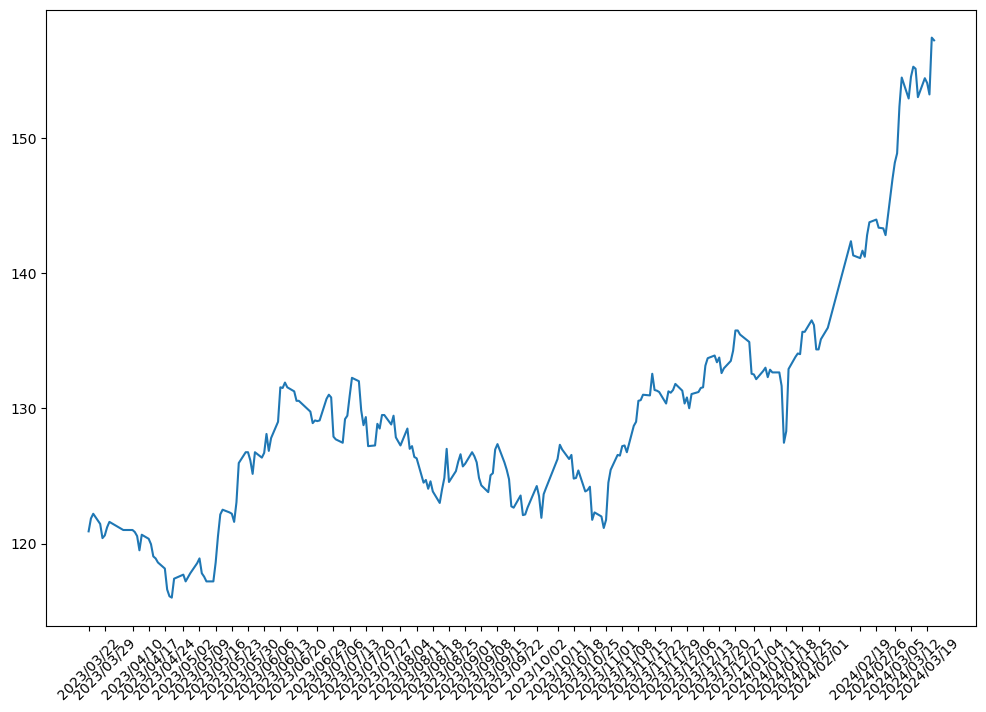

tensor([[-1.0290, -0.9055, -0.8599,  ..., -1.0681, -0.9900, -0.9380],
        [-0.9055, -0.8599, -0.9575,  ..., -0.9900, -0.9380, -1.0160],
        [-0.8599, -0.9575, -1.0941,  ..., -0.9380, -1.0160, -1.0160],
        ...,
        [ 3.3353,  3.1337,  3.3418,  ...,  3.1467,  3.3288,  3.2833],
        [ 3.1337,  3.3418,  3.4394,  ...,  3.3288,  3.2833,  3.1727],
        [ 3.3418,  3.4394,  3.4199,  ...,  3.2833,  3.1727,  3.7191]])


In [110]:
# 数据集建立
train_data, all_series, df_index = getData(df, 'Close', days_before=DAYS_BEFORE, train_end=TRAIN_END)
# print(getData(df, 'Close', days_before=DAYS_BEFORE ,train_end=TRAIN_END,return_all=False))
# 获取所有原始数据
all_series = np.array(all_series.tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# 归一化，便与训练
train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std  = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)
# print(train_data_numpy)
# 创建 dataloader
print(train_data_tensor)
train_set = TrainSet(train_data_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

In [111]:
#訓練
#  rnn = torch.load('rnn.pkl') 
rnn = LSTM()
if torch.cuda.is_available():
    rnn = rnn.cuda()

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.MSELoss()

for step in range(EPOCH):
    for tx, ty in train_loader:
        
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda()       
        
        output = rnn(torch.unsqueeze(tx, dim=2))
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # back propagation, compute gradients
        optimizer.step()
    print(step, loss.cpu())
    if step % 10:
        torch.save(rnn, 'rnn.pkl')
torch.save(rnn, 'rnn.pkl')

0 tensor(0.3871, grad_fn=<MseLossBackward0>)
1 tensor(0.7772, grad_fn=<MseLossBackward0>)
2 tensor(0.3692, grad_fn=<MseLossBackward0>)
3 tensor(1.1836, grad_fn=<MseLossBackward0>)
4 tensor(0.8094, grad_fn=<MseLossBackward0>)
5 tensor(0.6960, grad_fn=<MseLossBackward0>)
6 tensor(0.7456, grad_fn=<MseLossBackward0>)
7 tensor(0.8065, grad_fn=<MseLossBackward0>)
8 tensor(0.1079, grad_fn=<MseLossBackward0>)
9 tensor(1.2537, grad_fn=<MseLossBackward0>)
10 tensor(0.3462, grad_fn=<MseLossBackward0>)
11 tensor(0.6469, grad_fn=<MseLossBackward0>)
12 tensor(0.3779, grad_fn=<MseLossBackward0>)
13 tensor(0.0407, grad_fn=<MseLossBackward0>)
14 tensor(0.0191, grad_fn=<MseLossBackward0>)
15 tensor(0.2512, grad_fn=<MseLossBackward0>)
16 tensor(0.1072, grad_fn=<MseLossBackward0>)
17 tensor(0.0225, grad_fn=<MseLossBackward0>)
18 tensor(0.0956, grad_fn=<MseLossBackward0>)
19 tensor(0.1350, grad_fn=<MseLossBackward0>)
20 tensor(0.0132, grad_fn=<MseLossBackward0>)
21 tensor(0.0709, grad_fn=<MseLossBackward0>

179 tensor(0.0322, grad_fn=<MseLossBackward0>)
180 tensor(0.0355, grad_fn=<MseLossBackward0>)
181 tensor(0.0280, grad_fn=<MseLossBackward0>)
182 tensor(0.0180, grad_fn=<MseLossBackward0>)
183 tensor(0.0641, grad_fn=<MseLossBackward0>)
184 tensor(0.0096, grad_fn=<MseLossBackward0>)
185 tensor(0.0040, grad_fn=<MseLossBackward0>)
186 tensor(0.0542, grad_fn=<MseLossBackward0>)
187 tensor(0.0450, grad_fn=<MseLossBackward0>)
188 tensor(0.0219, grad_fn=<MseLossBackward0>)
189 tensor(0.0274, grad_fn=<MseLossBackward0>)
190 tensor(0.0299, grad_fn=<MseLossBackward0>)
191 tensor(0.0786, grad_fn=<MseLossBackward0>)
192 tensor(0.0276, grad_fn=<MseLossBackward0>)
193 tensor(0.0589, grad_fn=<MseLossBackward0>)
194 tensor(0.0444, grad_fn=<MseLossBackward0>)
195 tensor(0.0265, grad_fn=<MseLossBackward0>)
196 tensor(0.0173, grad_fn=<MseLossBackward0>)
197 tensor(0.0481, grad_fn=<MseLossBackward0>)
198 tensor(0.0309, grad_fn=<MseLossBackward0>)
199 tensor(0.0177, grad_fn=<MseLossBackward0>)
200 tensor(0.

355 tensor(0.0750, grad_fn=<MseLossBackward0>)
356 tensor(0.1154, grad_fn=<MseLossBackward0>)
357 tensor(0.0053, grad_fn=<MseLossBackward0>)
358 tensor(0.0280, grad_fn=<MseLossBackward0>)
359 tensor(0.1199, grad_fn=<MseLossBackward0>)
360 tensor(0.0166, grad_fn=<MseLossBackward0>)
361 tensor(0.0162, grad_fn=<MseLossBackward0>)
362 tensor(0.0076, grad_fn=<MseLossBackward0>)
363 tensor(0.0143, grad_fn=<MseLossBackward0>)
364 tensor(0.0096, grad_fn=<MseLossBackward0>)
365 tensor(0.0263, grad_fn=<MseLossBackward0>)
366 tensor(0.0079, grad_fn=<MseLossBackward0>)
367 tensor(0.0308, grad_fn=<MseLossBackward0>)
368 tensor(0.0140, grad_fn=<MseLossBackward0>)
369 tensor(0.0244, grad_fn=<MseLossBackward0>)
370 tensor(0.0200, grad_fn=<MseLossBackward0>)
371 tensor(0.0190, grad_fn=<MseLossBackward0>)
372 tensor(0.0196, grad_fn=<MseLossBackward0>)
373 tensor(0.0224, grad_fn=<MseLossBackward0>)
374 tensor(0.0243, grad_fn=<MseLossBackward0>)
375 tensor(0.0326, grad_fn=<MseLossBackward0>)
376 tensor(0.

530 tensor(0.0183, grad_fn=<MseLossBackward0>)
531 tensor(0.0149, grad_fn=<MseLossBackward0>)
532 tensor(0.0057, grad_fn=<MseLossBackward0>)
533 tensor(0.0052, grad_fn=<MseLossBackward0>)
534 tensor(0.0036, grad_fn=<MseLossBackward0>)
535 tensor(0.0184, grad_fn=<MseLossBackward0>)
536 tensor(0.0355, grad_fn=<MseLossBackward0>)
537 tensor(0.0075, grad_fn=<MseLossBackward0>)
538 tensor(0.0372, grad_fn=<MseLossBackward0>)
539 tensor(0.0097, grad_fn=<MseLossBackward0>)
540 tensor(0.0264, grad_fn=<MseLossBackward0>)
541 tensor(0.0221, grad_fn=<MseLossBackward0>)
542 tensor(0.0241, grad_fn=<MseLossBackward0>)
543 tensor(0.0420, grad_fn=<MseLossBackward0>)
544 tensor(0.0068, grad_fn=<MseLossBackward0>)
545 tensor(0.0022, grad_fn=<MseLossBackward0>)
546 tensor(0.0214, grad_fn=<MseLossBackward0>)
547 tensor(0.0212, grad_fn=<MseLossBackward0>)
548 tensor(0.0379, grad_fn=<MseLossBackward0>)
549 tensor(0.0117, grad_fn=<MseLossBackward0>)
550 tensor(0.0180, grad_fn=<MseLossBackward0>)
551 tensor(0.

705 tensor(0.0119, grad_fn=<MseLossBackward0>)
706 tensor(0.0143, grad_fn=<MseLossBackward0>)
707 tensor(0.0072, grad_fn=<MseLossBackward0>)
708 tensor(0.0113, grad_fn=<MseLossBackward0>)
709 tensor(0.0107, grad_fn=<MseLossBackward0>)
710 tensor(0.0318, grad_fn=<MseLossBackward0>)
711 tensor(0.0162, grad_fn=<MseLossBackward0>)
712 tensor(0.0158, grad_fn=<MseLossBackward0>)
713 tensor(0.0320, grad_fn=<MseLossBackward0>)
714 tensor(0.0274, grad_fn=<MseLossBackward0>)
715 tensor(0.0094, grad_fn=<MseLossBackward0>)
716 tensor(0.0063, grad_fn=<MseLossBackward0>)
717 tensor(0.0176, grad_fn=<MseLossBackward0>)
718 tensor(0.0124, grad_fn=<MseLossBackward0>)
719 tensor(0.0073, grad_fn=<MseLossBackward0>)
720 tensor(0.0059, grad_fn=<MseLossBackward0>)
721 tensor(0.0216, grad_fn=<MseLossBackward0>)
722 tensor(0.0216, grad_fn=<MseLossBackward0>)
723 tensor(0.0292, grad_fn=<MseLossBackward0>)
724 tensor(0.0370, grad_fn=<MseLossBackward0>)
725 tensor(0.0052, grad_fn=<MseLossBackward0>)
726 tensor(0.

882 tensor(0.0152, grad_fn=<MseLossBackward0>)
883 tensor(0.0054, grad_fn=<MseLossBackward0>)
884 tensor(0.0264, grad_fn=<MseLossBackward0>)
885 tensor(0.0148, grad_fn=<MseLossBackward0>)
886 tensor(0.0156, grad_fn=<MseLossBackward0>)
887 tensor(0.0748, grad_fn=<MseLossBackward0>)
888 tensor(0.0093, grad_fn=<MseLossBackward0>)
889 tensor(0.0129, grad_fn=<MseLossBackward0>)
890 tensor(0.0404, grad_fn=<MseLossBackward0>)
891 tensor(0.0213, grad_fn=<MseLossBackward0>)
892 tensor(0.0485, grad_fn=<MseLossBackward0>)
893 tensor(0.0180, grad_fn=<MseLossBackward0>)
894 tensor(0.0152, grad_fn=<MseLossBackward0>)
895 tensor(0.0090, grad_fn=<MseLossBackward0>)
896 tensor(0.0114, grad_fn=<MseLossBackward0>)
897 tensor(0.0464, grad_fn=<MseLossBackward0>)
898 tensor(0.0042, grad_fn=<MseLossBackward0>)
899 tensor(0.0091, grad_fn=<MseLossBackward0>)
900 tensor(0.0110, grad_fn=<MseLossBackward0>)
901 tensor(0.0159, grad_fn=<MseLossBackward0>)
902 tensor(0.0097, grad_fn=<MseLossBackward0>)
903 tensor(0.

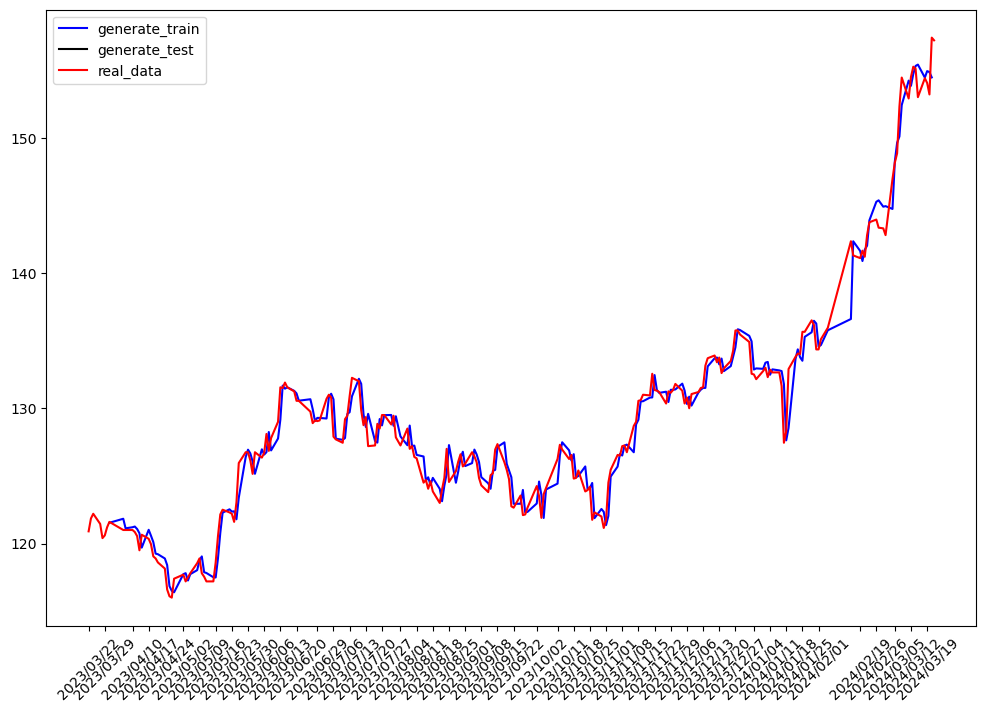

In [112]:
generate_data_train = []
generate_data_test = []

# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END

# 对所有的数据进行相同的归一化
all_series = (all_series - train_mean) / train_std
all_series = torch.Tensor(all_series)

for i in range(DAYS_BEFORE, len(all_series)):
    x = all_series[i - DAYS_BEFORE:i]
    # 将 x 填充到 (bs, ts, is) 中的 timesteps
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)

    if torch.cuda.is_available():
        x = x.cuda()

    y = rnn(x)
    
    if i < test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    else:
        generate_data_test.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
        
plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


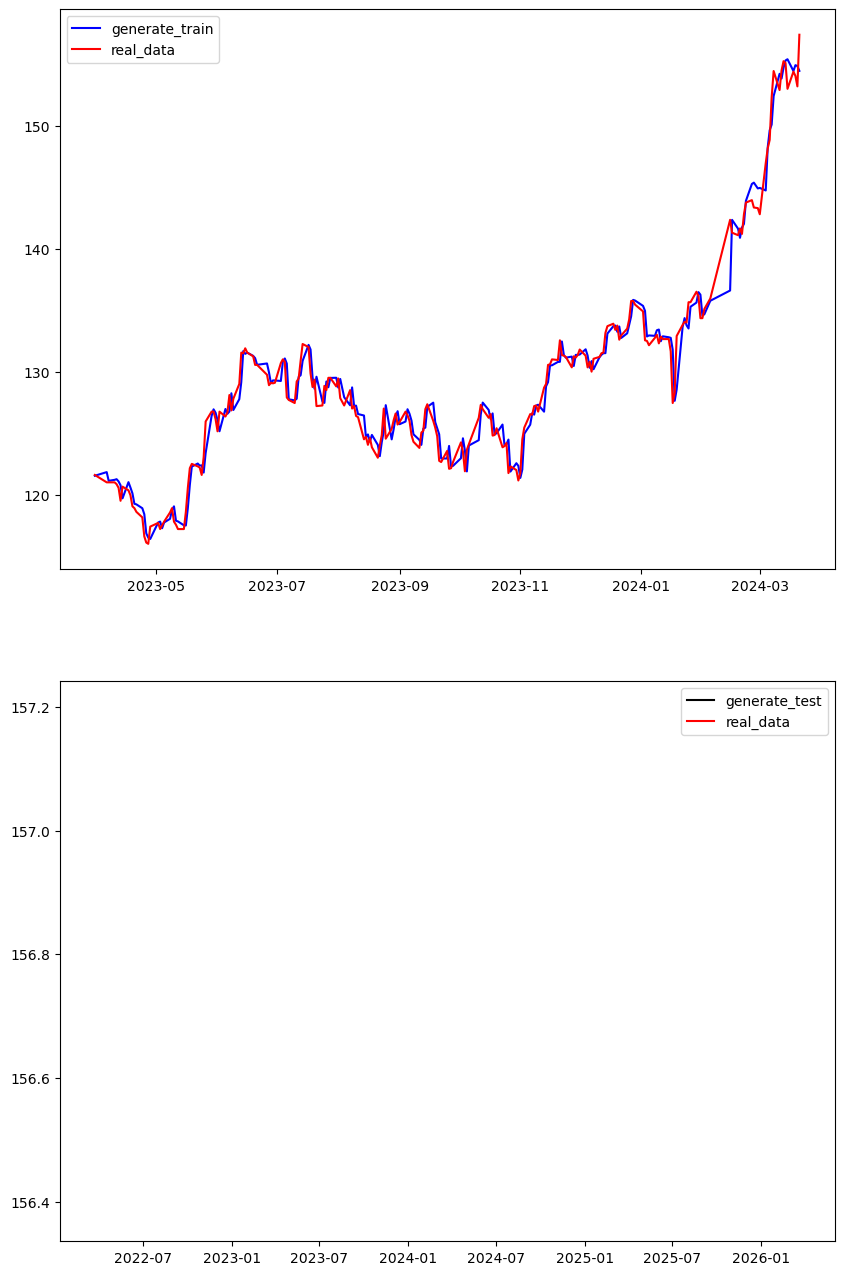

In [113]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

In [114]:
ans=[]
xx1 = all_series[- DAYS_BEFORE:]
xx1 = torch.unsqueeze(torch.unsqueeze(xx1, dim=0), dim=2)
yy1 = rnn(xx1)
for i in range(0, 5):
    xx1 = all_series[- DAYS_BEFORE:]
    xx1 = torch.unsqueeze(torch.unsqueeze(xx1, dim=0), dim=2)
    yy1 = rnn(xx1)
    all_series=torch.cat((all_series, yy1.detach().view(-1)), dim=0)
    ans.append(torch.squeeze(yy1.cpu()).detach().numpy() * train_std + train_mean)
    print(ans)


[156.65222730218102]
[156.65222730218102, 156.43376367141386]
[156.65222730218102, 156.43376367141386, 156.26587375352264]
[156.65222730218102, 156.43376367141386, 156.26587375352264, 156.13343162068378]
[156.65222730218102, 156.43376367141386, 156.26587375352264, 156.13343162068378, 156.06130259008896]
